# Importing Libraries

In [1]:
!pip install -q pyarabic
!pip install imbalanced-learn

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)
import pyarabic.araby as araby
import string
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
import tensorflow_datasets as tfds
import nltk
from wordcloud import WordCloud
import joblib


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#EDA


In [6]:
df = pd.read_csv('/content/drive/MyDrive/all_poems.csv')

In [8]:
df.head(3)

,poem_id,poem_link,poem_style,poem_text,poem_title,poet_cat,poet_id,poet_link,poet_name
0,21,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,أنشودة المطر,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب
1,65546,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,أقداح و أحلام,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب
2,65561,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,هوى واحد !,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58021 entries, 0 to 58020
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   poem_id     58021 non-null  int64 
 1   poem_link   58021 non-null  object
 2   poem_style  58021 non-null  object
 3   poem_text   58020 non-null  object
 4   poem_title  58021 non-null  object
 5   poet_cat    58021 non-null  object
 6   poet_id     58021 non-null  int64 
 7   poet_link   58021 non-null  object
 8   poet_name   58021 non-null  object
dtypes: int64(2), object(7)
memory usage: 4.0+ MB


In [9]:
df = df[['poem_text', 'poet_cat']]

In [10]:
# Remove duplicates
df = df.drop_duplicates()
# Check for missing values
print(df.isnull().sum())
df = df.dropna()

poem_text    1
poet_cat     0
dtype: int64


In [12]:
df['poem_text'] = df['poem_text'].astype(str)

<ipython-input-12-965926c26ddf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['poem_text'] = df['poem_text'].astype(str)


In [13]:
df['poet_cat'].value_counts()

poet_cat
العصر العباسي          19400
العصر الأندلسي          6292
سوريا                   5031
مصر                     4770
لبنان                   4585
العراق                  4229
العصر الإسلامي          3698
السعودية                1928
فلسطين                  1710
العصر الجاهلي           1457
اليمن                    698
عمان                     608
الإمارات                 563
البحرين                  551
الجزائر                  405
السودان                  403
تونس                     351
الأردن                   263
ليبيا                    238
المغرب                   201
إيران                     90
أفغانستان                 70
شعراء العراق والشام       68
الكويت                    54
قطر                       22
موريتانيا                 15
Name: count, dtype: int64

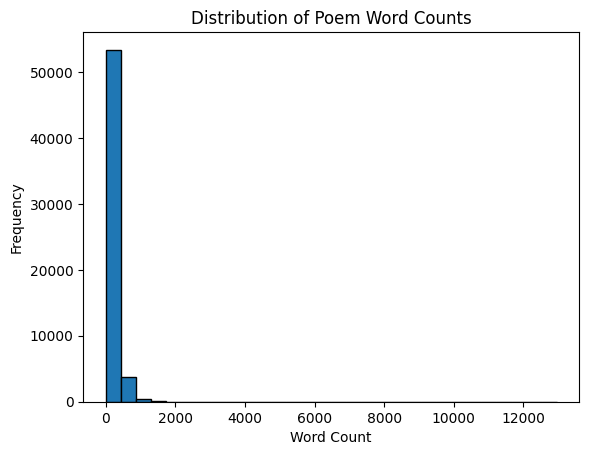

In [14]:
def count_words(text):
    return len(text.split())

# Count words in each poem
word_counts = df['poem_text'].apply(count_words)
plt.hist(word_counts, bins=30, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Poem Word Counts')
plt.show()

In [15]:
df = df[word_counts < 2000]
df

,poem_text,poet_cat
0,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,العراق
1,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,العراق
2,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,العراق
3,اساطير من حشرجات الزمان نسيج اليد البالية رواه...,العراق
4,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...,العراق
...,...,...
58016,لروح صهيل لا تحويه الاوقات ذنبك انك تمتد علي ا...,سوريا
58017,اه لو اني ابني الشمس بعيني من طين هواء وسراب م...,سوريا
58018,في عينيك يا امي لماذا الدمع منتظم كعقد الءلء ا...,سوريا
58019,النوم يوقظ طرفي الظامي علي لحن تموج من بعيد ار...,سوريا


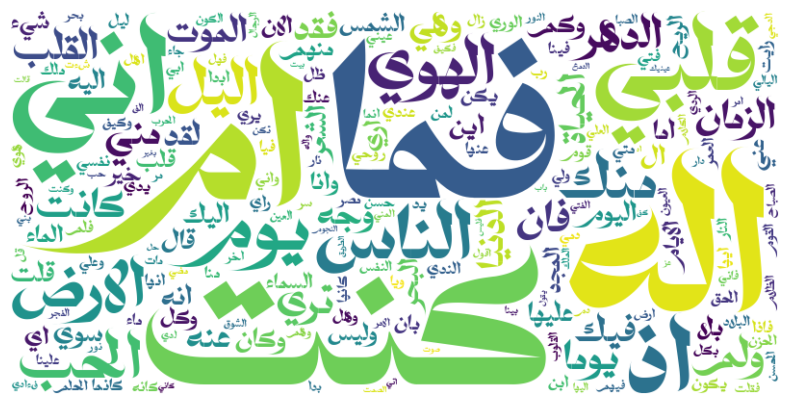

In [ ]:
# Arabic stopwords
arabic_stopwords = set(stopwords.words('arabic'))
# Add more stopwords
additional_stopwords = [ 'انت', "الى", "علي", "اذا", "حتي", "الي", "او", "انا","وان", "و", "الا", "واذا", "فهو","ان", "وفي", "وقد","وانت" ]
arabic_stopwords.update(additional_stopwords)

# Remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in arabic_stopwords]
    return ' '.join(filtered_words)

filtered_texts = df['poem_text'].apply(remove_stopwords)
filtered_text = ' '.join(filtered_texts)

# Display the word cloud
wordcloud = WordCloud(font_path='/content/drive/MyDrive/alfont_com_Foda-Free-Font.ttf', width=800, height=400, background_color='white').generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [16]:
# Select a sample of 20000 rows
df = df.sample(n=20000, random_state=42).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   poem_text  20000 non-null  object
 1   poet_cat   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


# Feature Extraction

In [18]:
# Text preprocessing and feature extraction
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['poem_text'])
y = df['poet_cat']

# Balance the data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

label_encoder = LabelEncoder()
y_resampled = label_encoder.fit_transform(y_resampled)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Machine Learning Models

##  Random Forest

In [ ]:
rf_clf = RandomForestClassifier( n_estimators= 200, max_depth= 60, random_state=42)
rf_clf.fit(X_train, y_train)

In [22]:
# Make predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9329085457271364
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1286
           1       1.00      1.00      1.00      1410
           2       1.00      1.00      1.00      1301
           3       1.00      0.96      0.98      1358
           4       0.98      0.92      0.95      1309
           5       1.00      0.98      0.99      1358
           6       0.98      0.93      0.95      1346
           7       1.00      0.99      1.00      1331
           8       0.97      0.88      0.93      1368
           9       0.84      0.78      0.81      1366
          10       0.63      0.93      0.76      1303
          11       0.64      0.96      0.77      1309
          12       0.63      0.45      0.52      1280
          13       1.00      1.00      1.00      1332
          14       1.00      1.00      1.00      1294
          15       1.00      0.95      0.97      1345
          16       0.99      

In [45]:
# Save Model
joblib.dump(rf_clf, 'random_forest_model.pkl')
# load model
#rf_clf = joblib.load('random_forest_model.pkl')

['random_forest_model.pkl']

##  Decision Tree

In [24]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_dt)
report = classification_report(y_test, y_pred_dt)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.9718313919963095
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1286
           1       0.99      1.00      1.00      1410
           2       0.99      1.00      1.00      1301
           3       0.99      1.00      1.00      1358
           4       0.99      1.00      1.00      1309
           5       1.00      1.00      1.00      1358
           6       0.96      1.00      0.98      1346
           7       0.99      1.00      1.00      1331
           8       0.93      0.98      0.96      1368
           9       0.88      0.92      0.90      1366
          10       0.91      0.99      0.95      1303
          11       0.97      1.00      0.98      1309
          12       0.86      0.43      0.57      1280
          13       1.00      1.00      1.00      1332
          14       1.00      1.00      1.00      1294
          15       0.99      1.00      1.00      1345
          16       1.00      

In [46]:
# Save Model
joblib.dump(rf_clf, 'decision_tree_model.pkl')
# load model
#rf_clf = joblib.load('decision_tree_model.pkl')

['decision_tree_model.pkl']

## Naive Bayes

In [30]:
NB_clf = MultinomialNB(alpha=0.5)

# Train the model
NB_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_NB = NB_clf.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_NB)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_NB)}")

Accuracy: 0.9669011648022143
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1286
           1       1.00      1.00      1.00      1410
           2       0.99      1.00      1.00      1301
           3       0.98      1.00      0.99      1358
           4       0.99      1.00      1.00      1309
           5       1.00      1.00      1.00      1358
           6       0.95      1.00      0.98      1346
           7       0.98      1.00      0.99      1331
           8       0.98      0.92      0.95      1368
           9       0.81      0.95      0.87      1366
          10       0.96      0.97      0.97      1303
          11       0.98      1.00      0.99      1309
          12       0.91      0.51      0.65      1280
          13       1.00      1.00      1.00      1332
          14       1.00      1.00      1.00      1294
          15       0.98      1.00      0.99      1345
          16       0.99      

In [47]:
# Save Model
joblib.dump(rf_clf, 'Naive_Bayes_model.pkl')
# load model
#rf_clf = joblib.load('Naive_Bayes_model.pkl')

['Naive_Bayes_model.pkl']

## Ensemble Learning

In [31]:
# Voting classifier
voting_clf = VotingClassifier(estimators=[
    ('dt', dt_clf),
    ('rf', rf_clf),
    ('NB', NB_clf)
], voting='soft')  # Use 'soft' for probability-based voting

# Train the ensemble model
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9717737285203553
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1286
           1       0.99      1.00      1.00      1410
           2       0.99      1.00      1.00      1301
           3       0.99      1.00      1.00      1358
           4       0.99      1.00      1.00      1309
           5       1.00      1.00      1.00      1358
           6       0.96      1.00      0.98      1346
           7       1.00      1.00      1.00      1331
           8       0.94      0.98      0.96      1368
           9       0.88      0.93      0.90      1366
          10       0.91      0.99      0.95      1303
          11       0.97      1.00      0.98      1309
          12       0.85      0.42      0.57      1280
          13       1.00      1.00      1.00      1332
          14       1.00      1.00      1.00      1294
          15       0.99      1.00      1.00      1345
          16       1.00      

In [48]:
# Save Model
joblib.dump(rf_clf, 'Ensemble_model.pkl')
# load model
#rf_clf = joblib.load('Ensemble_model.pkl')

['Ensemble_model.pkl']